In [1]:
# Author: Nicholas A. Ondo
# License:  MIT License

## <b>Introduction:</b>

This notebook sets up the basic utilities for exploring the probabilities within card games.  The basic question that will be explored and addressed is <b>"Given a deck of named cards, what is the probability of drawing a list of specific cards in the opening hand?"

This will be explored in two ways:

* One, by developing a Monte Carlo simulation that plays many randomized games, and then performs a statistical analysis on the runs to determine the underlying probability.  Here the basic input are two files, namely "deck.deck" and "hand.hand", alongside a global HAND_SIZE variable.  Additionally, NUM_RUNS will determine how many games are run in the Monte Carlo simulation.

* Two, by directly appealing to the known probability results.  This kind of question can be easily verified in any introductory probability book to be a multi-hypregeometric distribution.  Knowing this, a small set of tools are programmed to directly analytically compute the answer.


---
## <b>Part I: Loading Game Parameters.</b>

We store most of the game information in a "deck.deck" file, which holds the list of named cards in the deck, and a "hand.hand" file, which holds the list cards needed to define a "good" opening hand.

<b>I.a: Deck Data.</b> We need to start by loading the deck (tuple of card names), and specifying the other important game parameters (e.g. HANDSIZE):

In [2]:
# loadDeck() function
def load_deck(fileName):
    """load_deck loads .deck files into a list of trimmed card names."""
  
    try:
        with open(fileName + ".deck", 'r') as f:
            cards = f.readlines()
            return tuple(x.strip() for x in cards)
    except Exception as e:
        print(f"load_deck ERROR: Exception {e}\n")
        return None
    

N.B. 1: A functional programming approach is being taken here, therefore I am choosing immutable underlying structures, but at this level it is not highly important.

N.B. 2: An efficiency tactic might be adding a name aliasing function that shortens the names, but it would need to draw the goodcards and the deck at the same time.  This would shorten look up time, as well as protect against long search times for cards with long names.

<b>I.b: Good Hand Data.</b> Load the cards that are required to make a hand "good" into an immutable collection.

In [3]:
# load_goodHand() function

def load_good_hand(fileName):
    """Loads the list of needed cards to define a "good" hand."""

    try:
        with open(fileName + ".hand", 'r') as f:
            goodCards = f.readlines()
            return tuple(x.strip() for x in goodCards) # Process the card names 
    except Exception as e:
        print(f"load_goodCards ERROR: Exception {e}\n")
        return None
    

<b>I.c: Grabbing the Data.</b>  Let's grab the data from the local files with our loading functions.

Note that for our starter data, we choose a simple:

* A good hand counts as simply having a single card named "Card A".
* There are 4 of "Card A" in the 52 card deck.
* Since the other cards don't matter, they are called "Card B" WLOG.
* The number of cards drawn is 6.

Notice that this is isomorphic to asking, "What's the probability to drawing a specific card (e.g. a Jack) of any suit if I picked up 6 cards off of a shufled deck?"

In [4]:
# Load in the data

from pprint import pprint
from collections import Counter

DECK = load_deck("deck")
GOODHAND = load_good_hand("hand")
DECKSIZE = len(DECK)

print(f"The deck of {DECKSIZE} cards has these cards:")
pprint(Counter(DECK))
print("\nAnd your good hand needs these cards:")
pprint(Counter(GOODHAND))

HANDSIZE = 6
DECKSIZE = len(DECK)
GRAPH_TITLE = "Monte-Carlo Probability of Drawing {} in the Deck.".format("a Single Jack")

The deck of 52 cards has these cards:
Counter({'Card B': 48, 'Card A': 4})

And your good hand needs these cards:
Counter({'Card A': 1})


---

## <b>Part II: Estimates via Monte Carlo Simulations</b>

Here we take the approach of coding the games behavior, and then running a large number of games to empirically determine the underlying probability for drawing a "good" hand.

<b>II.a: Setting up automated runs for the game.

In [5]:
NUM_RUNS = 1 * 10**5

<b>II.a.I: Draw Hand From Shuffled Deck.</b>

Write functionality for drawing hand.  For efficiency, we only shuffle the cards needed for a full hand, not the entire deck.

In [6]:
# drawHand()
from random import sample, randrange

def drawHand(handSize, deckSize, deck):
    """Takes a deck and handSize and returns a re-ordered hand."""
    
    shuffled_indices = set()
    while len(shuffled_indices) < handSize:
        shuffled_indices.add(randrange(deckSize))

    return tuple(deck[i] for i in shuffled_indices)


<b>II.a.II: Automating the Run of a Game.</b>

Here we add in the functionality for checking if the hand we have randomly drawn is a good hand.  We return 1 and 0 so later on, we can do statistics on this data.

In [7]:
# runGame()

def runGame(_):
    """
    checkHand sees if the handDrawn is a good hand. If it is good, it returns 1, otherwise 0.
    """
    
    handDrawn = drawHand(HANDSIZE, DECKSIZE, DECK)
    goodHand, handDrawn = Counter(GOODHAND), Counter(handDrawn)
    
    for goodcard in goodHand:
        if goodcard in handDrawn and (handDrawn[goodcard] - goodHand[goodcard] >= 0):
            pass
        else:
            return 0
    return 1


<b>II.b: Run the Games.</b>

Here we run the MC simulations and collect the raw data in an np.array named "runs".

In [8]:
# Setup runs
from time import time
import numpy as np

runs = np.arange(NUM_RUNS)

# Perform and time runs
t_begin = time()
runs = np.array(list(map(runGame, runs)))
t_end = time()

print(f'Data generation of {len(runs)} runs took {(t_end - t_begin):.4f} seconds.')

Data generation of 100000 runs took 1.8893 seconds.



---
## Part III: Analytic Estimates

Here we will generate an analytic estimate (exact probability) by applying a multi-hypergeometric distrubtion to get the answer.

This will then be used to look at statistical parameters in Part IV.

<b>III.a.I: Multi-Hypergeometric PMF</b>

Here I define some useful utility functions related to multi-hypergeometric probabilities.

In [9]:
from scipy.misc import comb as choose

def multi_hyperg_pmf(N, Klist, n, klist):
    """
    Multi-hypergeometric prob of drawing at least (k_i) number of cards.
    -- N is the num cards in the deck.
    -- Klist is the list of each desired cards in the deck.
    -- n is the hand size.
    -- Klist is the list of the exact number of each kind
       of desired cards in the hand.
    Returns the probability of acquiring such a hand.
    """ 
    prob = 1 / choose(N, n)
    for K, k in zip(Klist, klist):
        prob *= choose(K, k)
    
    # prob of what's left over 
    prob *= choose(N - sum(Klist), n - sum(klist))
    
    return prob


def theory1_prob(N, Klist, n, klist):
    """
    Uses the PMF to compute each individual win condition,
    then sums over all winning combinations to get the total probability.
    """
    
    if Klist is None or klist is None or Klist == list() or klist == list():
        raise TypeError("Klist and klist must not be None or empty.")
    prob = 0
    for comb in win_combs(Klist, klist, n):
        prob += multi_hyperg_pmf(N, Klist, n, comb)
    
    return prob

Since we are summing over complex win conditions, it is helpful to write a custom generator that contains this logic and yields the individual win cases. i.e.

In [10]:
from itertools import product


def win_combs(cards_indeck, cards_needed, hand_size):
    """
    Generator for the winning combinations.
    Returns comb, a list of integers such that
    -- The sum(comb) <= hand_size.
    -- For each i, Klist[i] >= comb[i] >= klist[i].
    """
    
    all_combs = list()
    for i, numcards in enumerate(cards_needed):
        all_combs += [
            list(range(numcards, 1 + min(hand_size, cards_indeck[i])))]
    
    for comb in product(*all_combs):
        if sum(comb) <= hand_size:
            yield list(comb)

N.B. The previous method is an inferior way of generating the winning hand combinations for large, complex hands. Since we have still technically won if we get more cards than just the required number, we have many additional combinations of hands that count as "winning" hands. It is inferior because we generate, in principle, many more hands than are needed, for large combinations of needed hands and larger hand sizes, the combinatorics of the extraneous non-winning hands are created through the Cartesian product (itertools.product) will be large. Therefore, if this code needed to be scaled, a custom implementation of the Cartesian product would be needed, or an alternative approach entirely (e.g. the probability tree method.)

<b>III.a.II: Generating Data needed for Analytic Estimate</b>

Now we use generate the inputs for these utilities from our underlying game parameters.  Recall that:

* N is the num cards in the deck.
* Klist is the list of each desired cards in the deck.
* n is the hand size.
* Klist is the list of the exact number of each kind of desired cards in the hand.

In [11]:
# Generate this data from DECK, GOODHAND, and HANDSIZE:
goodhand_bin = Counter(GOODHAND)
deck_bin = Counter(DECK)

numcardtypes_hand = tuple(goodhand_bin[name] for name in goodhand_bin)
pprint(f"Number each type of card in a good hand: {numcardtypes_hand}.")

numcardtypes_deck = list()
for cardname in goodhand_bin:
    if cardname in deck_bin:
        numcardtypes_deck.append(deck_bin[cardname])
    else:
        raise ValueError("There are cards in the hand that don't exist in deck. Check files.")

pprint(f"Number of each type of good card in the deck: {numcardtypes_deck}.")

'Number each type of card in a good hand: (1,).'
'Number of each type of good card in the deck: [4].'


<b>III.a.III: The Analytic Estimate</b>

Now we finally compute the first analytic result.

In [12]:
analytic_prob = theory1_prob(DECKSIZE, numcardtypes_deck, HANDSIZE, numcardtypes_hand)

print(f"The exact probability is {analytic_prob}.")

The exact probability is 0.3972296610952073.


---

## <b>Part IV: Statistical Analysis</b>

<b>IV.a: Define Point Statistics.</b> Define the point statistics, here using the standard Monte Carlo simulation method, i.e. the average of point distributions converges to the underlying probability, and then comparing this to the exact probability.

In [13]:
# Point Distrubtion statistics

def game_probs(runs):
    """
    game_probs: Homebrew empirical mass function, i.e. directly average over
    the given 0 or 1 conditions of the runs.
    -- Returns running array of probabilities.
    """
    
    stepwise_prob = []
    accum = 0
    
    for i in range(len(runs)):
        accum += runs[i]        
        running_avg = accum / (i + 1.0)
        stepwise_prob.append(running_avg)
        
    return stepwise_prob

def game_stats(runs, probs, indices):
    """
    game_stderrs: Homebrew standard error function for graphing.
    -- Returns x, y, and yerr for data at each index in indices.
    """
    
    # A better solution here would be to compute backwards, so sums are only computed once.
    stepwise_x = [i for i in indices]
    stepwise_y = [probs[i] for i in indices]
    
    stepwise_yerr = []
    indices = [i for i in indices if i != 0]
    
    for i in indices:
        stepwise_yerr.append(1.95 * np.sqrt(sum([(x - probs[i])**2 for x in runs[:i]]) / (i + i**2)))
    
    return stepwise_x, stepwise_y, stepwise_yerr

# N.B. One can also use the obviously more efficient scipy.stats functions.


<b>IV.b: Perform Point Statistics.</b>

Compute and store running statistical information for graphing.  Here we compute the error by using a normal estimator for the error.  For larger runs, this will be an increasingly reliable estimator.

In [14]:
t_begin = time()
probs = game_probs(runs)
t_end = time()

print(f"Doing the statistics took {(t_end - t_begin):.4f} seconds.")
print(f"Monte Carlo probability estimator: {probs[-1]}.")

Doing the statistics took 0.3635 seconds.
Monte Carlo probability estimator: 0.3985.


<b>IV.c: Plot the Running Probability as a Function of Runs</b>

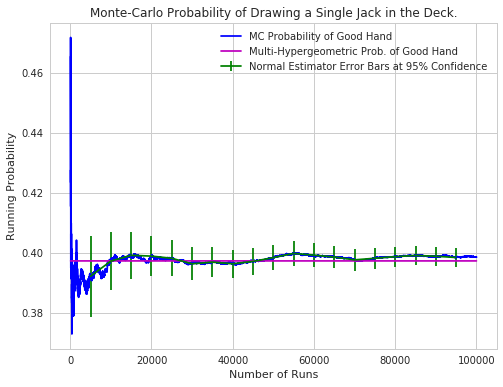

In [15]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="whitegrid")

x_offset = 10**2

# Collate data for exact result
x_runs = np.arange(NUM_RUNS)
true_probs = [analytic_prob for _ in range(NUM_RUNS)]

# Collate and automate error bars
num_errbars = 20
delta = NUM_RUNS // num_errbars
errbar_ind = [i for i in range(len(x_runs)) if i % delta == 0 and i >= x_offset]
x_errbar, y_errbar, y_err = game_stats(runs, probs, errbar_ind)

# Plot the data
plt.figure(figsize=(8,6))
plt.plot(x_runs[x_offset:], probs[x_offset:], label='MC Probability of Good Hand', color="b")
plt.errorbar(x_errbar, y_errbar, yerr=y_err, color="g", label="Normal Estimator Error Bars at 95% Confidence")
plt.plot(x_runs[x_offset:], true_probs[x_offset:], label='Multi-Hypergeometric Prob. of Good Hand', color="m")
plt.xlabel('Number of Runs')
plt.ylabel('Running Probability')
plt.title(GRAPH_TITLE)
plt.legend()
plt.show()


<b>A concluding note on efficiency:</b> For the case of drawing a Jack (total of 4 Jacks in the deck) out of a standard 52 card deck within an opening hand size of 6 cards is 0.397229661095  (correct up to 12 digits).  This current method on a 4th gen core i5 processor completes 5 million runs in 96 s; cf. to an older method that ran for 529 s over 5 million runs and gives 0.396176, this is a ~5.29x optimization by only drawing the cards needed from the hand rather than the whole deck, using optimized objects (e.g. Counter) from the Pythong standard library, and cleaning up the code base.  That being said, if one is deeply concerned about efficiency, the fastest code possible will be re-writing this in either C/C++ or Cython, and importing it Python side.  Still, it's nice to show how to do basic MC statistics totally inside of Python.